In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

# Set up plotting styles
sns.set_style("whitegrid")
%matplotlib inline

# Define paths to data files based on the project structure
data_path = "../data/"
fraud_data_path = data_path + "Fraud_Data.csv"
ip_data_path = data_path + "IpAddress_to_Country.csv"
creditcard_data_path = data_path + "creditcard.csv"

print("Libraries imported and data paths defined.")

Libraries imported and data paths defined.


In [2]:
# Load the three datasets
try:
    df_fraud = pd.read_csv(fraud_data_path)
    df_ip = pd.read_csv(ip_data_path)
    df_creditcard = pd.read_csv(creditcard_data_path)
    
    print("Datasets loaded successfully.")
    
    # Display the first few rows of each dataframe to verify
    print("\nFraud_Data.csv head:")
    print(df_fraud.head())
    print("\nIpAddress_to_Country.csv head:")
    print(df_ip.head())
    print("\ncreditcard.csv head:")
    print(df_creditcard.head())

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the data files are in the 'data' directory.")

Datasets loaded successfully.

Fraud_Data.csv head:
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  

IpAddress_to_Country.csv head:
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0             

In [3]:
# Check for missing values
print("Missing values in Fraud_Data.csv:")
print(df_fraud.isnull().sum())

Missing values in Fraud_Data.csv:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64


In [4]:
# Convert 'signup_time' and 'purchase_time' to datetime objects
df_fraud['signup_time'] = pd.to_datetime(df_fraud['signup_time'])
df_fraud['purchase_time'] = pd.to_datetime(df_fraud['purchase_time'])

print("\nData types after conversion:")
print(df_fraud.info())


Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB
None


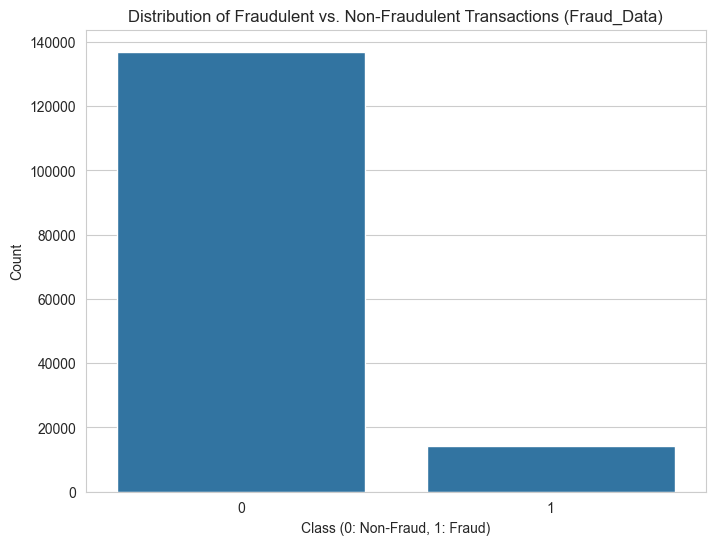

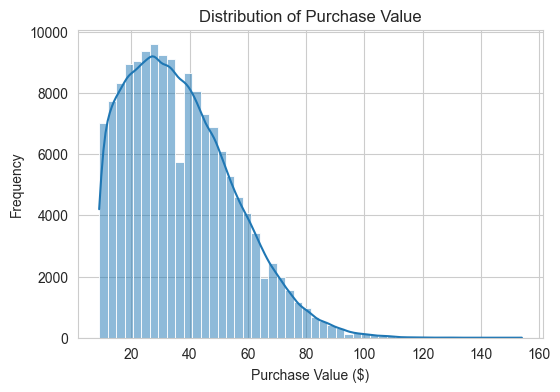

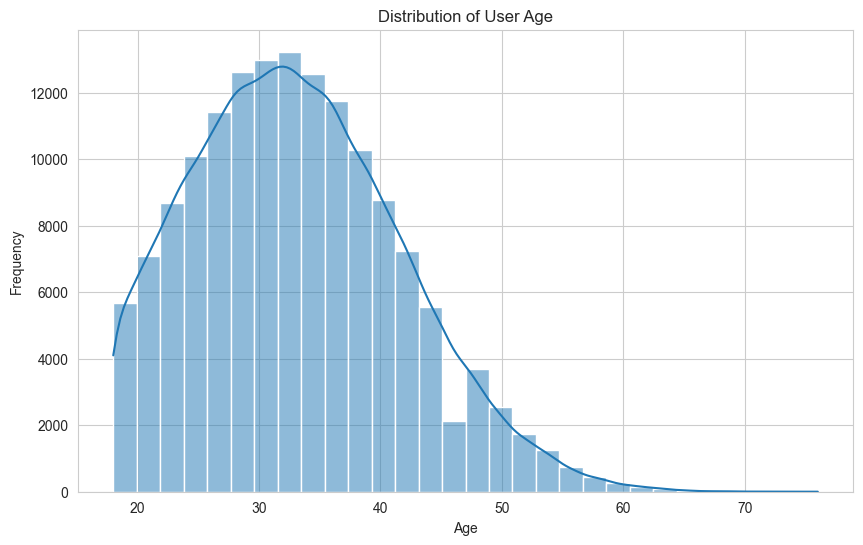

In [5]:
# Class distribution (critical challenge)
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df_fraud)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions (Fraud_Data)')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

# Distribution of 'purchase_value'
plt.figure(figsize=(6,4))
sns.histplot(df_fraud['purchase_value'], bins=50, kde=True)
plt.title('Distribution of Purchase Value')
plt.xlabel('Purchase Value ($)')
plt.ylabel('Frequency')
plt.show()

# Distribution of 'age'
plt.figure(figsize=(10, 6))
sns.histplot(df_fraud['age'], bins=30, kde=True)
plt.title('Distribution of User Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

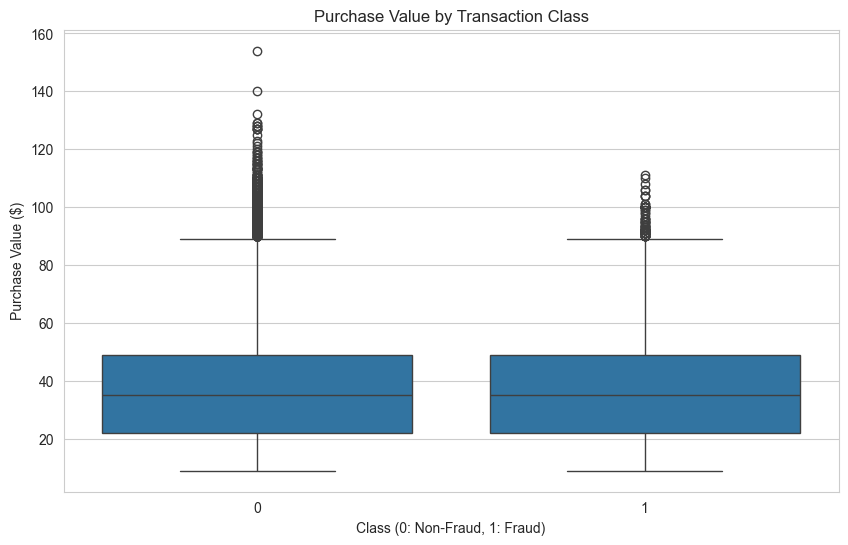

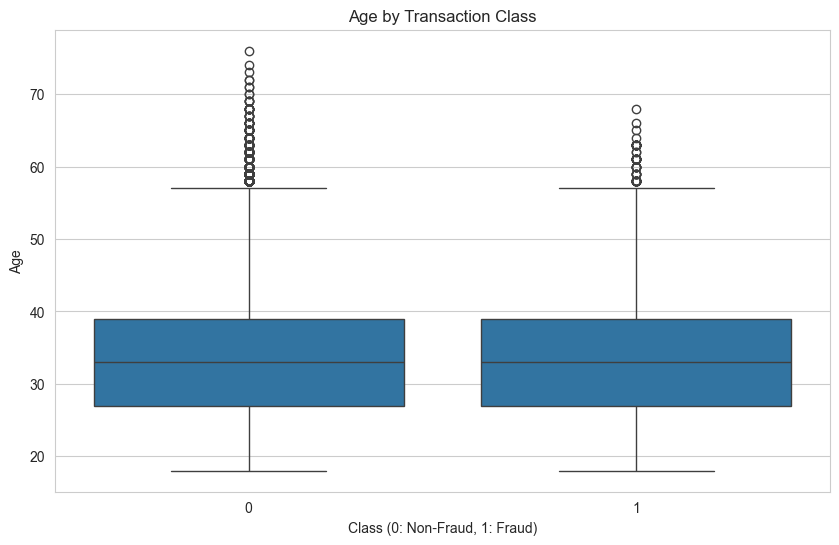

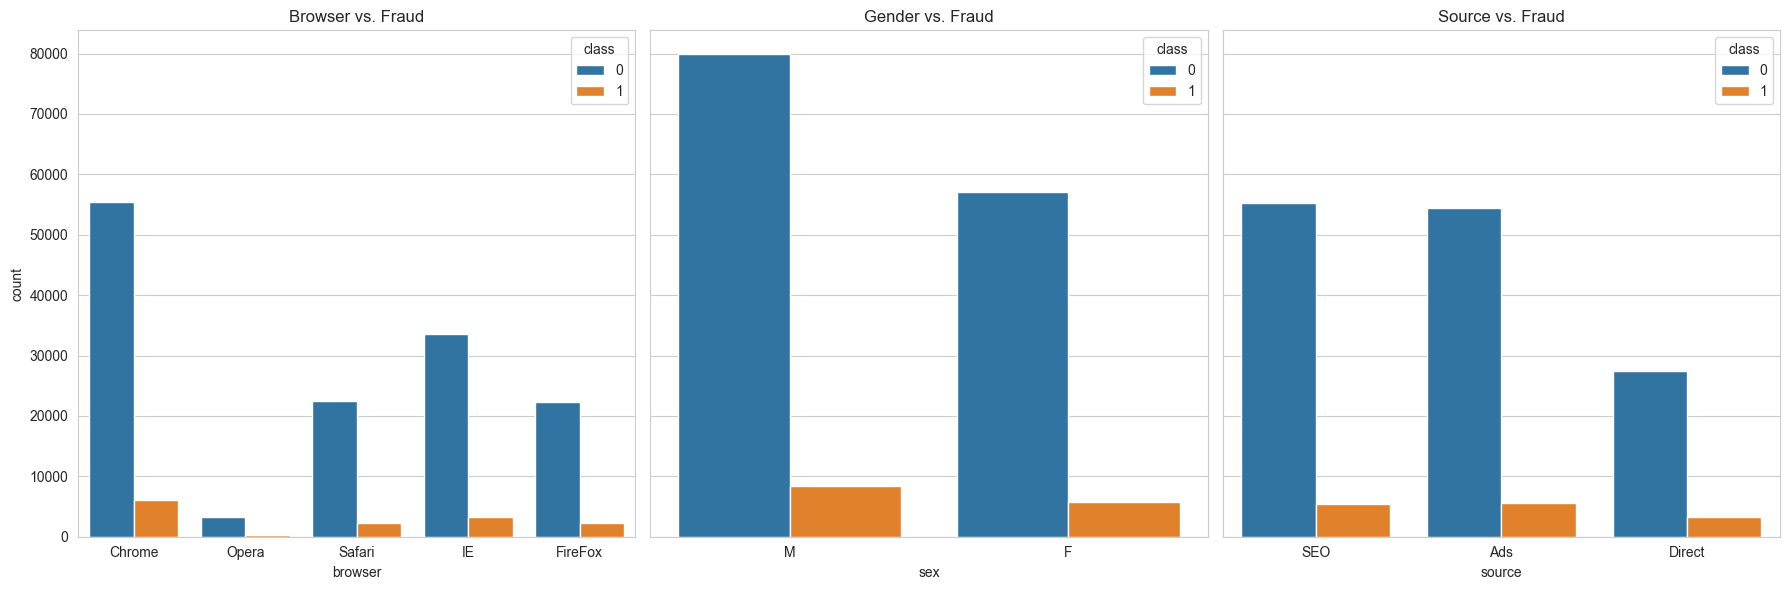

In [6]:
# Purchase value distribution for fraud vs. non-fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=df_fraud)
plt.title('Purchase Value by Transaction Class')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Purchase Value ($)')
plt.show()

# Age distribution for fraud vs. non-fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='age', data=df_fraud)
plt.title('Age by Transaction Class')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Age')
plt.show()

# Categorical features vs. fraud
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.countplot(x='browser', hue='class', data=df_fraud, ax=axes[0])
axes[0].set_title('Browser vs. Fraud')
sns.countplot(x='sex', hue='class', data=df_fraud, ax=axes[1])
axes[1].set_title('Gender vs. Fraud')
sns.countplot(x='source', hue='class', data=df_fraud, ax=axes[2])
axes[2].set_title('Source vs. Fraud')
plt.tight_layout()
plt.show()

In [7]:
import ipaddress # Keep this for standard IP parsing

# Assuming df_fraud and df_ip are already loaded

def ip_to_int(ip_address_val):
    """
    Converts an IP address to a 32-bit integer.
    Handles dotted decimal strings, integer-like floats, and NaNs.
    Prioritizes converting numerical strings/floats to integers.
    """
    if pd.isna(ip_address_val):
        return np.nan

    # Try to convert to float first. This will catch '732758368.79972'
    # and turn it into the float 732758368.79972.
    try:
        numeric_ip = float(ip_address_val)
        # If it's successfully converted to a float, assume it's a numeric IP
        # and truncate the decimal part by converting to int.
        return int(numeric_ip)
    except ValueError:
        # If it's not directly convertible to a float, it might be a standard
        # dotted-decimal IP string (e.g., "192.168.1.1").
        try:
            # Use the ipaddress module for proper validation and conversion
            return int(ipaddress.ip_address(str(ip_address_val)))
        except (ipaddress.AddressValueError, ValueError):
            # This catches both invalid IP formats from ipaddress and other ValueErrors
            print(f"Warning: Could not convert IP address '{ip_address_val}' to integer. Returning NaN.")
            return np.nan

# --- Apply to DataFrames ---
# It's still good practice to ensure they are string objects for consistency
# and to avoid pandas type inference issues, even if the function can handle numbers.
df_fraud['ip_address'] = df_fraud['ip_address'].astype(str)
df_fraud['ip_address_int'] = df_fraud['ip_address'].apply(ip_to_int)

df_ip['lower_bound_ip_address'] = df_ip['lower_bound_ip_address'].astype(str)
df_ip['upper_bound_ip_address'] = df_ip['upper_bound_ip_address'].astype(str)
df_ip['lower_bound_ip_int'] = df_ip['lower_bound_ip_address'].apply(ip_to_int)
df_ip['upper_bound_ip_int'] = df_ip['upper_bound_ip_address'].apply(ip_to_int)

print("\nIP addresses converted to integers (with robust handling of float-like strings).")

# --- Sample and merge (as you had it) ---
# Note: For accurate results on the merge, you should ideally convert the *entire* df_fraud
# rather than just a sample, and then perform the merge.
# For demonstration purposes, your sampling might be okay, but be mindful of data loss.
df_fraud_sample = df_fraud.sample(n=1000, random_state=42)

# Ensure df_ip has the 'lower_bound_ip_int' and 'upper_bound_ip_int' columns fully populated
# (apply ip_to_int to the full df_ip before passing it to find_country)
# And the find_country function relies on these numeric ranges.

# Define find_country if not already defined (or ensure it's in scope)
def find_country(ip_int, df_ip_ranges):
    """Finds the country for a given IP address integer."""
    if pd.isna(ip_int):
        return 'Unknown'
    country = df_ip_ranges[(df_ip_ranges['lower_bound_ip_int'] <= ip_int) &
                           (df_ip_ranges['upper_bound_ip_int'] >= ip_int)]['country']
    if not country.empty:
        return country.iloc[0]
    return 'Unknown'


df_fraud_sample['country'] = df_fraud_sample['ip_address_int'].apply(find_country, df_ip_ranges=df_ip)

# Display the result
print(df_fraud_sample[['ip_address', 'ip_address_int', 'country', 'class']].head())

# Check for any NaNs introduced due to conversion issues (e.g., bad IP formats)
print("\nMissing values in new IP integer columns after improved conversion:")
print(df_fraud['ip_address_int'].isnull().sum())
print(df_ip['lower_bound_ip_int'].isnull().sum())
print(df_ip['upper_bound_ip_int'].isnull().sum())


IP addresses converted to integers (with robust handling of float-like strings).
              ip_address  ip_address_int            country  class
92865   3315147387.22793      3315147387            Morocco      0
50746   991628325.615216       991628325  Korea Republic of      0
128421  274442709.665377       274442709      United States      0
146243  2654816479.51674      2654816479      United States      1
44524   1419979966.38594      1419979966            Germany      0

Missing values in new IP integer columns after improved conversion:
0
0
0


In [9]:

# If you only applied to sample before, apply to the full dataframe now:
print("Applying country lookup to the full df_fraud. This might take a while...")
df_fraud['country'] = df_fraud['ip_address_int'].apply(find_country, df_ip_ranges=df_ip)
print("Country lookup complete for full df_fraud.")

# Verify a few entries with country
print(df_fraud[['ip_address', 'ip_address_int', 'country', 'class']].head())
print(f"Number of 'Unknown' countries: {df_fraud[df_fraud['country'] == 'Unknown'].shape[0]}")

Applying country lookup to the full df_fraud. This might take a while...
Country lookup complete for full df_fraud.
         ip_address  ip_address_int        country  class
0   732758368.79972       732758368          Japan      0
1  350311387.865908       350311387  United States      0
2  2621473820.11095      2621473820  United States      1
3  3840542443.91396      3840542443        Unknown      0
4  415583117.452712       415583117  United States      0
Number of 'Unknown' countries: 21966


In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') # Keep this for now to suppress other warnings if any

# Assuming df_fraud is loaded and 'purchase_time' is a datetime object
# And country data has been merged

# --- Time-Based Features (Recap & Re-run to ensure consistency) ---
df_fraud['hour_of_day'] = df_fraud['purchase_time'].dt.hour
df_fraud['day_of_week'] = df_fraud['purchase_time'].dt.day_name()
df_fraud['month_of_year'] = df_fraud['purchase_time'].dt.month
df_fraud['day_of_year'] = df_fraud['purchase_time'].dt.dayofyear

# Calculate time_since_signup (in hours)
df_fraud['time_since_signup'] = (df_fraud['purchase_time'] - df_fraud['signup_time']).dt.total_seconds() / 3600

original_index = df_fraud.index

# Sort by group ID and then by time for each group
df_fraud.sort_values(by=['user_id', 'purchase_time'], inplace=True)

# Function to calculate rolling features within a group, preserving original index
def calculate_rolling_features_robust(group_df, time_col, window_size):
    # Ensure the group is sorted by time (important for rolling)
    group_df = group_df.sort_values(by=time_col)
    
    # Create a Series for rolling, with the original index and time column as values
    # The rolling function needs a datetime-like index to use '24H' etc.
    # We will use the 'purchase_time' as the index for the rolling calculation itself.
    # The result will have the 'purchase_time' as its index.
    rolling_result = group_df.set_index(time_col).rolling(window_size)['purchase_value'].count() - 1
    
    aligned_results = pd.Series(rolling_result.values, index=group_df.index)
    
    return aligned_results

df_fraud['user_transactions_24h'] = df_fraud.groupby('user_id', group_keys=False).apply(
    lambda x: calculate_rolling_features_robust(x, 'purchase_time', '24H')
)

df_fraud['user_transactions_7d'] = df_fraud.groupby('user_id', group_keys=False).apply(
    lambda x: calculate_rolling_features_robust(x, 'purchase_time', '7D')
)

# Sort by device_id and then by time for each group
df_fraud.sort_values(by=['device_id', 'purchase_time'], inplace=True)

# Apply to device_id
df_fraud['device_transactions_24h'] = df_fraud.groupby('device_id', group_keys=False).apply(
    lambda x: calculate_rolling_features_robust(x, 'purchase_time', '24H')
)

df_fraud['device_transactions_7d'] = df_fraud.groupby('device_id', group_keys=False).apply(
    lambda x: calculate_rolling_features_robust(x, 'purchase_time', '7D')
)

# Ensure the DataFrame is sorted back by its original index if needed for later steps
# df_fraud = df_fraud.loc[original_index].copy() # This might be useful if order matters for subsequent ops

print("\nEngineered features added to df_fraud:")
print(df_fraud[['purchase_time', 'time_since_signup', 'hour_of_day', 'day_of_week',
                'user_transactions_24h', 'device_transactions_24h', 'country']].head())

# Check for NaNs that might be introduced by rolling operations (e.g., first few transactions)
print("\nMissing values after feature engineering (rolling features):")
print(df_fraud[['user_transactions_24h', 'device_transactions_24h', 'user_transactions_7d', 'device_transactions_7d']].isnull().sum())

# Fill NaNs created by rolling features (they will be 0 for the first transaction in a group)
for col in ['user_transactions_24h', 'device_transactions_24h', 'user_transactions_7d', 'device_transactions_7d']:
    df_fraud[col].fillna(0, inplace=True)

print("\nMissing values after filling NaNs:")
print(df_fraud[['user_transactions_24h', 'device_transactions_24h', 'user_transactions_7d', 'device_transactions_7d']].isnull().sum())

# Ensure dtypes are integer after filling NaNs if appropriate
df_fraud['user_transactions_24h'] = df_fraud['user_transactions_24h'].astype(int)
df_fraud['device_transactions_24h'] = df_fraud['device_transactions_24h'].astype(int)
df_fraud['user_transactions_7d'] = df_fraud['user_transactions_7d'].astype(int)
df_fraud['device_transactions_7d'] = df_fraud['device_transactions_7d'].astype(int)

print("\nData types after feature engineering:")
print(df_fraud[['user_transactions_24h', 'device_transactions_24h', 'user_transactions_7d', 'device_transactions_7d']].dtypes)


Engineered features added to df_fraud:
            purchase_time  time_since_signup  hour_of_day day_of_week  \
34321 2015-06-13 23:42:18         775.696389           23    Saturday   
57616 2015-03-29 00:39:07        1226.317500            0      Sunday   
46520 2015-07-22 03:18:01        1754.468889            3   Wednesday   
69175 2015-01-01 04:25:23           0.000278            4    Thursday   
35860 2015-01-01 04:25:24           0.000278            4    Thursday   

       user_transactions_24h  device_transactions_24h         country  
34321                    0.0                      0.0  United Kingdom  
57616                    0.0                      0.0   United States  
46520                    0.0                      0.0         Unknown  
69175                    0.0                      0.0  United Kingdom  
35860                    0.0                      1.0  United Kingdom  

Missing values after feature engineering (rolling features):
user_transactions_24h      

In [11]:

import warnings
warnings.filterwarnings('ignore')

print("\n--- Data Transformation for Fraud_Data.csv ---")

# Drop original time columns (already extracted features from them)
# Drop IDs as they are not direct features for the model (used for grouping/merging)
# Keep 'ip_address_int' as a numerical feature.
X_fraud = df_fraud.drop([
    'class',
    'signup_time',
    'purchase_time',
    'ip_address', # Original string IP, 'ip_address_int' is the feature
    'user_id',    # Used for feature engineering, not direct model input
    'device_id'   # Used for feature engineering, not direct model input
], axis=1)
y_fraud = df_fraud['class']
print(X_fraud.head())
print(y_fraud.head())

print(f"Features (X_fraud) shape: {X_fraud.shape}")
print(f"Target (y_fraud) shape: {y_fraud.shape}")

# 1.2 Split Data into Training and Testing Sets
# Stratify to maintain class distribution in both train and test sets
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

print("\nFraud_Data split into training and testing sets:")
print(f"X_train_fraud shape: {X_train_fraud.shape}, y_train_fraud shape: {y_train_fraud.shape}")
print(f"X_test_fraud shape: {X_test_fraud.shape}, y_test_fraud shape: {y_test_fraud.shape}")
print(f"Training set class distribution:\n{y_train_fraud.value_counts(normalize=True)}")
print(f"Test set class distribution:\n{y_test_fraud.value_counts(normalize=True)}")


--- Data Transformation for Fraud_Data.csv ---
       purchase_value  source  browser sex  age  ip_address_int  \
34321              45  Direct   Chrome   M   34      2494581089   
57616              94     Ads   Chrome   M   29       809263681   
46520              46     Ads       IE   M   40         2891496   
69175              57     Ads  FireFox   F   36      1377849233   
35860              57     Ads  FireFox   F   36      1377849233   

              country  hour_of_day day_of_week  month_of_year  day_of_year  \
34321  United Kingdom           23    Saturday              6          164   
57616   United States            0      Sunday              3           88   
46520         Unknown            3   Wednesday              7          203   
69175  United Kingdom            4    Thursday              1            1   
35860  United Kingdom            4    Thursday              1            1   

       time_since_signup  user_transactions_24h  user_transactions_7d  \
34321  

In [12]:
# 2.1 Identify Numerical and Categorical Features for Pipeline
numerical_features_fraud = [
    'purchase_value', 'age', 'time_since_signup',
    'user_transactions_24h', 'device_transactions_24h',
    'user_transactions_7d', 'device_transactions_7d',
    'hour_of_day', 'month_of_year', 'day_of_year',
    'ip_address_int'
]
categorical_features_fraud = [
    'source', 'browser', 'sex', 'day_of_week', 'country'
]

# Verify all features exist in the DataFrame
# This check is important, especially after feature engineering and dropping columns
missing_numerical = [col for col in numerical_features_fraud if col not in X_train_fraud.columns]
missing_categorical = [col for col in categorical_features_fraud if col not in X_train_fraud.columns]

if missing_numerical:
    print(f"WARNING: The following numerical features are missing from X_train_fraud: {missing_numerical}")
if missing_categorical:
    print(f"WARNING: The following categorical features are missing from X_train_fraud: {missing_categorical}")

# 2.2 Create Preprocessing Pipelines for Scaling and Encoding
# StandardScaler for numerical features (good for features with varying scales)
numeric_transformer_fraud = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# OneHotEncoder for nominal categorical features
categorical_transformer_fraud = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor_fraud = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_fraud, numerical_features_fraud),
        ('cat', categorical_transformer_fraud, categorical_features_fraud)
    ],
    remainder='passthrough' # 'passthrough' will keep any columns not specified
)

# 2.3 Handle Class Imbalance (SMOTE for Oversampling)
# We use imblearn's Pipeline to integrate SMOTE into a workflow.
# SMOTE is applied ONLY to the training data *after* preprocessing steps.

# Build the full preprocessing + sampling pipeline
pipeline_fraud_preprocessing = imbpipeline(steps=[
    ('preprocessor', preprocessor_fraud),
    ('sampler', SMOTE(random_state=42)) # Apply SMOTE after preprocessing
])

# Apply the pipeline to the training data
print("\nApplying preprocessing and SMOTE to Fraud_Data training set. This might take a moment...")
X_train_processed_fraud, y_train_resampled_fraud = pipeline_fraud_preprocessing.fit_resample(X_train_fraud, y_train_fraud)
print("Preprocessing and SMOTE complete for Fraud_Data training set.")

# Transform the test data using only the preprocessor fitted on training data
# IMPORTANT: Do NOT apply SMOTE to the test set!
X_test_processed_fraud = preprocessor_fraud.transform(X_test_fraud)

print("\nClass distribution in the training set after SMOTE:")
print(y_train_resampled_fraud.value_counts())

print("\nFraud_Data transformed (scaled, encoded, and resampled):")
print(f"Shape of processed training data (X_train_processed_fraud): {X_train_processed_fraud.shape}")
print(f"Shape of processed training labels (y_train_resampled_fraud): {y_train_resampled_fraud.shape}")
print(f"Shape of processed testing data (X_test_processed_fraud): {X_test_processed_fraud.shape}")
print(f"Shape of testing labels (y_test_fraud): {y_test_fraud.shape}")


Applying preprocessing and SMOTE to Fraud_Data training set. This might take a moment...
Preprocessing and SMOTE complete for Fraud_Data training set.

Class distribution in the training set after SMOTE:
class
0    109568
1    109568
Name: count, dtype: int64

Fraud_Data transformed (scaled, encoded, and resampled):
Shape of processed training data (X_train_processed_fraud): (219136, 206)
Shape of processed training labels (y_train_resampled_fraud): (219136,)
Shape of processed testing data (X_test_processed_fraud): (30223, 206)
Shape of testing labels (y_test_fraud): (30223,)



--- Data Cleaning and Preprocessing for creditcard.csv ---
Missing values in creditcard.csv:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Removed 1081 duplicate rows from creditcard.csv.


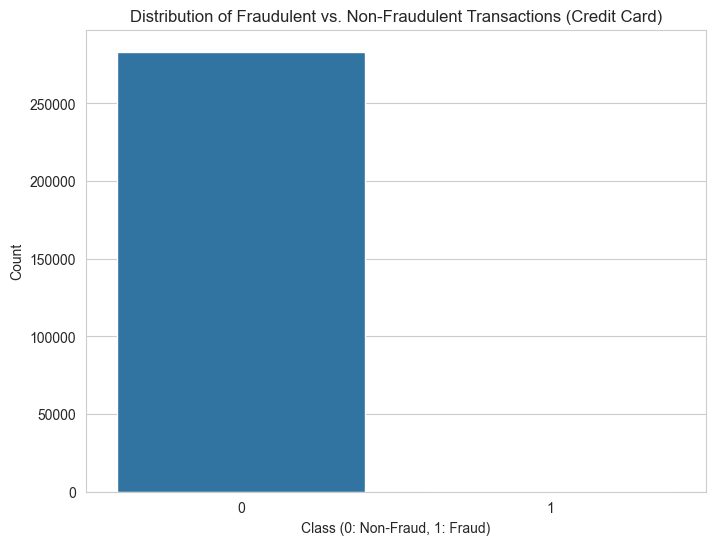

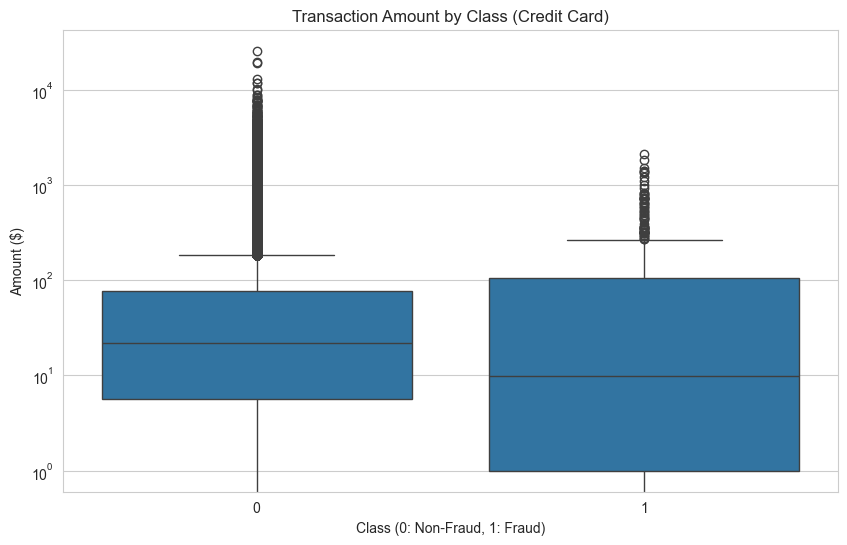

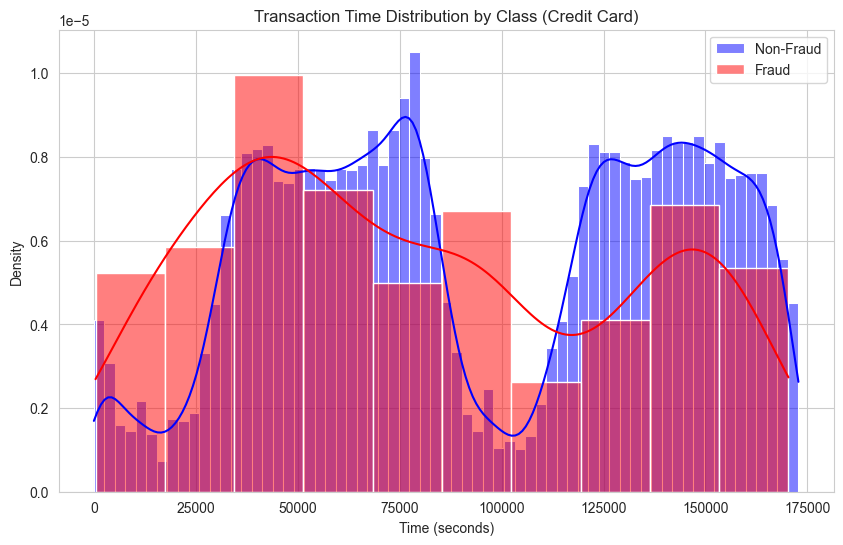

EDA for creditcard.csv completed.
Features (X_cc) shape: (283726, 30)
Target (y_cc) shape: (283726,)

Creditcard.csv data split into training and testing sets:
X_train_cc shape: (226980, 30), y_train_cc shape: (226980,)
X_test_cc shape: (56746, 30), y_test_cc shape: (56746,)
Training set class distribution:
Class
0    0.998335
1    0.001665
Name: proportion, dtype: float64
Test set class distribution:
Class
0    0.998326
1    0.001674
Name: proportion, dtype: float64

Applying StandardScaler to creditcard.csv training set...
Scaling complete for creditcard.csv training set.
Creditcard.csv data scaled.

Applying SMOTE to creditcard.csv training set...
SMOTE complete for creditcard.csv training set.

Class distribution in credit card training set after SMOTE:
Class
0    226602
1    226602
Name: count, dtype: int64

Creditcard.csv transformed (scaled and resampled):
Shape of processed training data (X_train_resampled_cc): (453204, 30)
Shape of processed training labels (y_train_resampled_

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_creditcard is already loaded

print("\n--- Data Cleaning and Preprocessing for creditcard.csv ---")

# 3.1 Handle Missing Values (Check)
print("Missing values in creditcard.csv:")
print(df_creditcard.isnull().sum())
# Typically, creditcard.csv is a clean dataset with no missing values.

# 3.2 Remove Duplicates (already did this, but re-confirming here for a complete script)
initial_rows_cc = df_creditcard.shape[0]
df_creditcard.drop_duplicates(inplace=True)
print(f"Removed {initial_rows_cc - df_creditcard.shape[0]} duplicate rows from creditcard.csv.")


# 3.3 Exploratory Data Analysis (Recap/Confirmation)
# Class distribution (critical challenge)
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df_creditcard)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions (Credit Card)')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

# Distribution of 'Amount' for fraud vs. non-fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df_creditcard)
plt.title('Transaction Amount by Class (Credit Card)')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Amount ($)')
plt.yscale('log') # Use log scale due to skewed distribution
plt.show()

# Distribution of 'Time' for fraud vs. non-fraud
plt.figure(figsize=(10, 6))
sns.histplot(df_creditcard[df_creditcard['Class'] == 0]['Time'], color='blue', kde=True, stat='density', alpha=0.5, label='Non-Fraud')
sns.histplot(df_creditcard[df_creditcard['Class'] == 1]['Time'], color='red', kde=True, stat='density', alpha=0.5, label='Fraud')
plt.title('Transaction Time Distribution by Class (Credit Card)')
plt.xlabel('Time (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()

print("EDA for creditcard.csv completed.")

# 3.4 Define Features (X) and Target (y)
X_cc = df_creditcard.drop('Class', axis=1)
y_cc = df_creditcard['Class']

print(f"Features (X_cc) shape: {X_cc.shape}")
print(f"Target (y_cc) shape: {y_cc.shape}")

# 3.5 Split Data into Training and Testing Sets
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc
)

print("\nCreditcard.csv data split into training and testing sets:")
print(f"X_train_cc shape: {X_train_cc.shape}, y_train_cc shape: {y_train_cc.shape}")
print(f"X_test_cc shape: {X_test_cc.shape}, y_test_cc shape: {y_test_cc.shape}")
print(f"Training set class distribution:\n{y_train_cc.value_counts(normalize=True)}")
print(f"Test set class distribution:\n{y_test_cc.value_counts(normalize=True)}")

# 3.6 Scaling Numerical Features
# All V features are already PCA transformed and generally scaled, but StandardScaler can still
# help optimize some algorithms that expect zero mean and unit variance.
# 'Time' and 'Amount' definitely benefit from scaling.
numerical_features_cc = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)]

scaler_cc = StandardScaler()

# Apply scaling to the training data
print("\nApplying StandardScaler to creditcard.csv training set...")
X_train_scaled_cc = scaler_cc.fit_transform(X_train_cc)
print("Scaling complete for creditcard.csv training set.")

# Apply the *fitted* scaler to the test data
X_test_scaled_cc = scaler_cc.transform(X_test_cc)

print("Creditcard.csv data scaled.")

# 3.7 Handle Class Imbalance (SMOTE for Oversampling)
# Apply SMOTE *after* scaling for credit card data
smote_cc = SMOTE(random_state=42)
print("\nApplying SMOTE to creditcard.csv training set...")
X_train_resampled_cc, y_train_resampled_cc = smote_cc.fit_resample(X_train_scaled_cc, y_train_cc)
print("SMOTE complete for creditcard.csv training set.")

print("\nClass distribution in credit card training set after SMOTE:")
print(y_train_resampled_cc.value_counts())

print("\nCreditcard.csv transformed (scaled and resampled):")
print(f"Shape of processed training data (X_train_resampled_cc): {X_train_resampled_cc.shape}")
print(f"Shape of processed training labels (y_train_resampled_cc): {y_train_resampled_cc.shape}")
print(f"Shape of processed testing data (X_test_scaled_cc): {X_test_scaled_cc.shape}")
print(f"Shape of testing labels (y_test_cc): {y_test_cc.shape}")


--- Task 2: Model Building and Training ---
Evaluation helper function defined.

--- Training and Evaluating Models for Fraud_Data.csv (E-commerce) ---

Training Logistic Regression for Fraud_Data...
Logistic Regression training complete.

--- Evaluation for Logistic Regression (Fraud_Data) ---

Confusion Matrix:
[[27264   129]
 [ 1467  1363]]


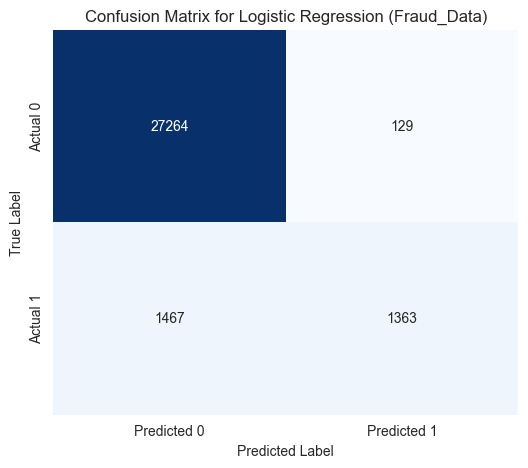


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.91      0.48      0.63      2830

    accuracy                           0.95     30223
   macro avg       0.93      0.74      0.80     30223
weighted avg       0.95      0.95      0.94     30223

AUC-ROC Score: 0.7652
AUC-PR Score: 0.6027
Average Precision Score: 0.6025
F1-Score (Positive Class): 0.6307
Accuracy: 0.9472

Training LightGBM Classifier for Fraud_Data...
[LightGBM] [Info] Number of positive: 109568, number of negative: 109568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17850
[LightGBM] [Info] Number of data points in the train set: 219136, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pav

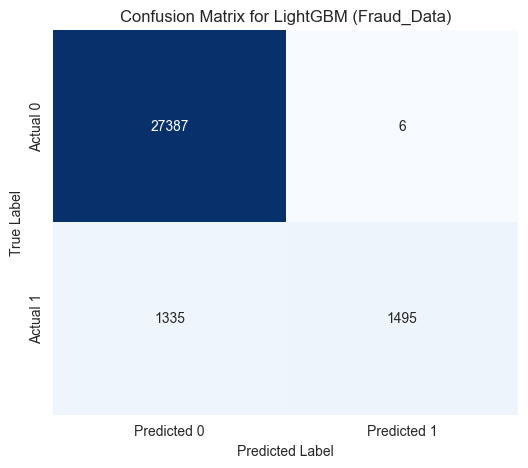


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

AUC-ROC Score: 0.7669
AUC-PR Score: 0.6230
Average Precision Score: 0.6230
F1-Score (Positive Class): 0.6904
Accuracy: 0.9556

--- Summary of Fraud_Data Model Performance ---
                                  roc_auc  auc_pr  f1_score  accuracy
model_name                                                           
Logistic Regression (Fraud_Data)   0.7652  0.6027    0.6307    0.9472
LightGBM (Fraud_Data)              0.7669  0.6230    0.6904    0.9556

--- Training and Evaluating Models for creditcard.csv (Bank Credit) ---

Training Logistic Regression for CreditCard.csv...
Logistic Regression training complete.

--- Evaluation for Logistic R

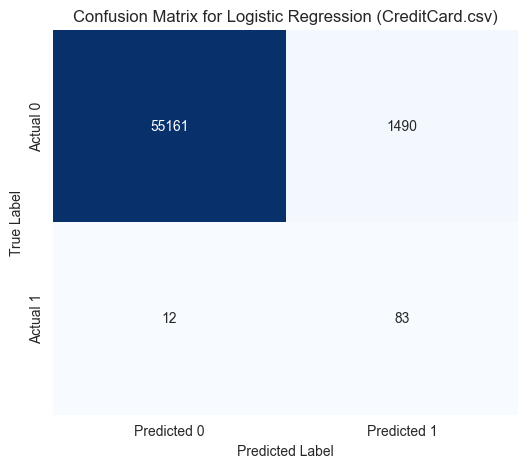


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746

AUC-ROC Score: 0.9626
AUC-PR Score: 0.7110
Average Precision Score: 0.6734
F1-Score (Positive Class): 0.0995
Accuracy: 0.9735

Training LightGBM Classifier for CreditCard.csv...
[LightGBM] [Info] Number of positive: 226602, number of negative: 226602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 453204, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Classifier training 

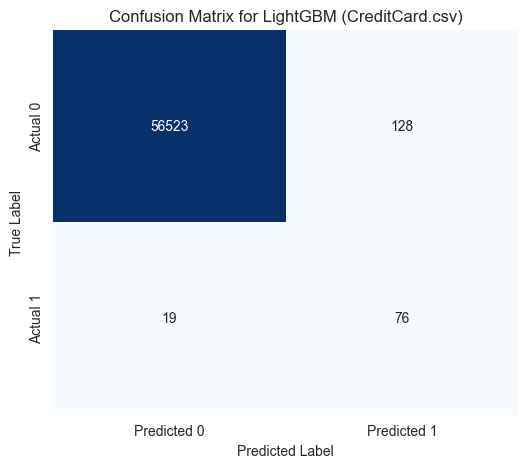


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.37      0.80      0.51        95

    accuracy                           1.00     56746
   macro avg       0.69      0.90      0.75     56746
weighted avg       1.00      1.00      1.00     56746

AUC-ROC Score: 0.9422
AUC-PR Score: 0.5822
Average Precision Score: 0.3691
F1-Score (Positive Class): 0.5084
Accuracy: 0.9974

--- Summary of CreditCard.csv Model Performance ---
                                      roc_auc  auc_pr  f1_score  accuracy
model_name                                                               
Logistic Regression (CreditCard.csv)   0.9626  0.7110    0.0995    0.9735
LightGBM (CreditCard.csv)              0.9422  0.5822    0.5084    0.9974


In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline # Alias to avoid confusion with sklearn Pipeline

# Specific imports for Task 2
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # Keep warnings suppressed for cleaner output

print("\n--- Task 2: Model Building and Training ---")

# --- Helper function for evaluation ---
def evaluate_model(model_name, y_true, y_pred, y_prob):
    """
    Evaluates a classification model using metrics suitable for imbalanced data.
    """
    print(f"\n--- Evaluation for {model_name} ---")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # AUC-ROC Score
    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"AUC-ROC Score: {roc_auc:.4f}")

    # AUC-PR (Area Under Precision-Recall Curve)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    auc_pr = auc(recall, precision)
    print(f"AUC-PR Score: {auc_pr:.4f}")

    # Average Precision Score (alternative to AUC-PR directly from sklearn)
    avg_precision = average_precision_score(y_true, y_prob)
    print(f"Average Precision Score: {avg_precision:.4f}")

    # F1-Score (for the positive class)
    f1 = f1_score(y_true, y_pred)
    print(f"F1-Score (Positive Class): {f1:.4f}")

    # Optional: Basic Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    return {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'auc_pr': auc_pr,
        'f1_score': f1,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

print("Evaluation helper function defined.")

# Ensure your X_train_processed_fraud, y_train_resampled_fraud, etc., are loaded from Task 1 execution.
# If not, you'll need to re-run your Task 1 code.

# --- Training and Evaluating Models for Fraud_Data.csv (E-commerce) ---
print("\n--- Training and Evaluating Models for Fraud_Data.csv (E-commerce) ---")

# --- Model 1: Logistic Regression ---
print("\nTraining Logistic Regression for Fraud_Data...")
lr_fraud = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
lr_fraud.fit(X_train_processed_fraud, y_train_resampled_fraud)
print("Logistic Regression training complete.")

# Predictions
y_pred_lr_fraud = lr_fraud.predict(X_test_processed_fraud)
y_prob_lr_fraud = lr_fraud.predict_proba(X_test_processed_fraud)[:, 1]

# Evaluate
eval_lr_fraud = evaluate_model("Logistic Regression (Fraud_Data)", y_test_fraud, y_pred_lr_fraud, y_prob_lr_fraud)


# --- Model 2: LightGBM Classifier ---
print("\nTraining LightGBM Classifier for Fraud_Data...")
lgbm_fraud = LGBMClassifier(random_state=42, n_estimators=1000, learning_rate=0.05, num_leaves=31,
                            objective='binary', metric='auc',
                            is_unbalance=True, # Recommended for imbalanced data in LightGBM
                            n_jobs=-1)

lgbm_fraud.fit(X_train_processed_fraud, y_train_resampled_fraud)
print("LightGBM Classifier training complete.")

# Predictions
y_pred_lgbm_fraud = lgbm_fraud.predict(X_test_processed_fraud)
y_prob_lgbm_fraud = lgbm_fraud.predict_proba(X_test_processed_fraud)[:, 1]

# Evaluate
eval_lgbm_fraud = evaluate_model("LightGBM (Fraud_Data)", y_test_fraud, y_pred_lgbm_fraud, y_prob_lgbm_fraud)

# --- Summarize Fraud_Data Results ---
print("\n--- Summary of Fraud_Data Model Performance ---")
results_fraud = pd.DataFrame([eval_lr_fraud, eval_lgbm_fraud]).set_index('model_name')
print(results_fraud[['roc_auc', 'auc_pr', 'f1_score', 'accuracy']].round(4))

# --- Training and Evaluating Models for creditcard.csv (Bank Credit) ---
print("\n--- Training and Evaluating Models for creditcard.csv (Bank Credit) ---")

# --- Model 1: Logistic Regression ---
print("\nTraining Logistic Regression for CreditCard.csv...")
lr_cc = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
lr_cc.fit(X_train_resampled_cc, y_train_resampled_cc)
print("Logistic Regression training complete.")

# Predictions
y_pred_lr_cc = lr_cc.predict(X_test_scaled_cc)
y_prob_lr_cc = lr_cc.predict_proba(X_test_scaled_cc)[:, 1]

# Evaluate
eval_lr_cc = evaluate_model("Logistic Regression (CreditCard.csv)", y_test_cc, y_pred_lr_cc, y_prob_lr_cc)


# --- Model 2: LightGBM Classifier ---
print("\nTraining LightGBM Classifier for CreditCard.csv...")
lgbm_cc = LGBMClassifier(random_state=42, n_estimators=1000, learning_rate=0.05, num_leaves=31,
                             objective='binary', metric='auc',
                             is_unbalance=True,
                             n_jobs=-1)

lgbm_cc.fit(X_train_resampled_cc, y_train_resampled_cc)
print("LightGBM Classifier training complete.")

# Predictions
y_pred_lgbm_cc = lgbm_cc.predict(X_test_scaled_cc)
y_prob_lgbm_cc = lgbm_cc.predict_proba(X_test_scaled_cc)[:, 1]

# Evaluate
eval_lgbm_cc = evaluate_model("LightGBM (CreditCard.csv)", y_test_cc, y_pred_lgbm_cc, y_prob_lgbm_cc)

# --- Summarize CreditCard.csv Results ---
print("\n--- Summary of CreditCard.csv Model Performance ---")
results_cc = pd.DataFrame([eval_lr_cc, eval_lgbm_cc]).set_index('model_name')
print(results_cc[['roc_auc', 'auc_pr', 'f1_score', 'accuracy']].round(4))


--- Task 3: Model Explainability with SHAP ---

--- SHAP Explanation for LightGBM (Fraud_Data) ---
Number of feature names generated for Fraud_Data by custom function: 206
Shape of X_test_processed_fraud: (30223, 206)

--- DEEPER DIAGNOSTIC FOR X_test_processed_fraud ---
Type of X_test_processed_fraud: <class 'scipy.sparse._csr.csr_matrix'>
Is X_test_processed_fraud a SciPy sparse matrix? Yes. Type: <class 'scipy.sparse._csr.csr_matrix'>
X_test_processed_fraud.shape: (30223, 206)
Converting sparse matrix to dense array for DataFrame creation...
New shape after toarray(): (30223, 206)
New type after toarray(): <class 'numpy.ndarray'>
--- END DEEPER DIAGNOSTIC ---
CONFIRMING SHAPE RIGHT BEFORE DATAFRAME: (30223, 206)
CONFIRMING COLUMN NAMES COUNT RIGHT BEFORE DATAFRAME: 206
Assertion passed: X_test_processed_fraud column count matches feature names count.
Shape of shap_sample_fraud (features for plot): (1000, 206)
Shape of shap_values_for_plot_fraud (SHAP values): (206,)


AssertionError: Mismatch in number of rows between features (shap_sample_fraud) and SHAP values! (Post .values fix)


--- Task 3: Model Explainability with SHAP ---

--- SHAP Explanation for LightGBM (Fraud_Data) ---
Number of feature names generated for Fraud_Data by custom function: 206
Shape of X_test_processed_fraud: (30223, 206)

--- DEEPER DIAGNOSTIC FOR X_test_processed_fraud ---
Type of X_test_processed_fraud: <class 'numpy.ndarray'>
Is X_test_processed_fraud a NumPy array? Yes.
X_test_processed_fraud.ndim: 2
X_test_processed_fraud.shape[0]: 30223
X_test_processed_fraud.shape[1]: 206
--- END DEEPER DIAGNOSTIC ---
CONFIRMING SHAPE RIGHT BEFORE DATAFRAME: (30223, 206)
CONFIRMING COLUMN NAMES COUNT RIGHT BEFORE DATAFRAME: 206
Assertion passed: X_test_processed_fraud column count matches feature names count.

Calculating SHAP values sample by sample (workaround for batch processing issue)...
Shape of shap_sample_fraud (features for plot): (1000, 206)
Shape of shap_values_for_plot_fraud (SHAP values): (1000, 206)

Generating SHAP Summary Plot for Fraud_Data...


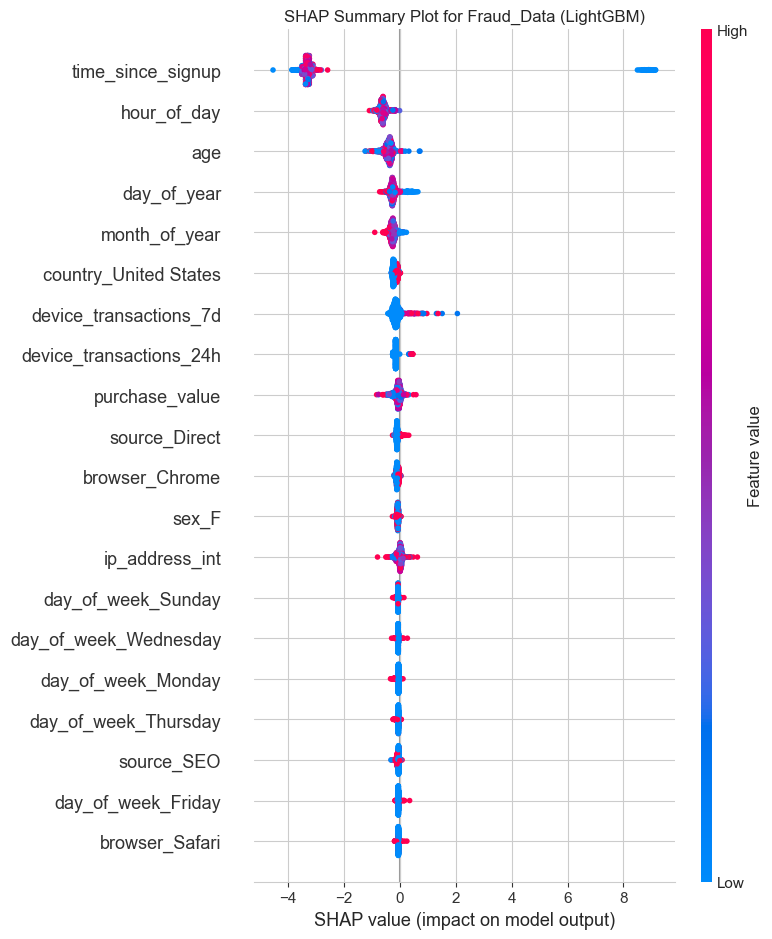


Generating SHAP Bar Plot for Fraud_Data...


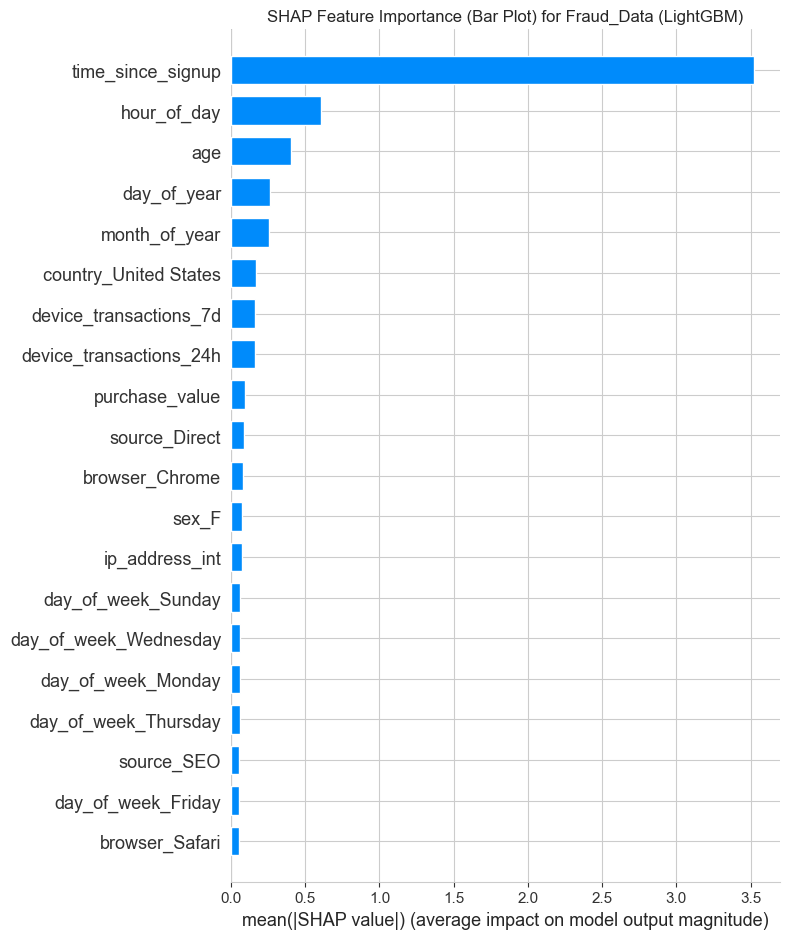


Generating SHAP Force Plot for a sample Fraud_Data transaction...


Force plot for a fraudulent transaction (index 2 in processed test set):



--- SHAP Explanation for LightGBM (creditcard.csv) ---

Calculating SHAP values sample by sample (workaround for batch processing issue)...
Shape of shap_sample_cc (features for plot): (1000, 30)
Shape of shap_values_for_plot_cc (SHAP values): (1000, 30)

Generating SHAP Summary Plot for creditcard.csv...


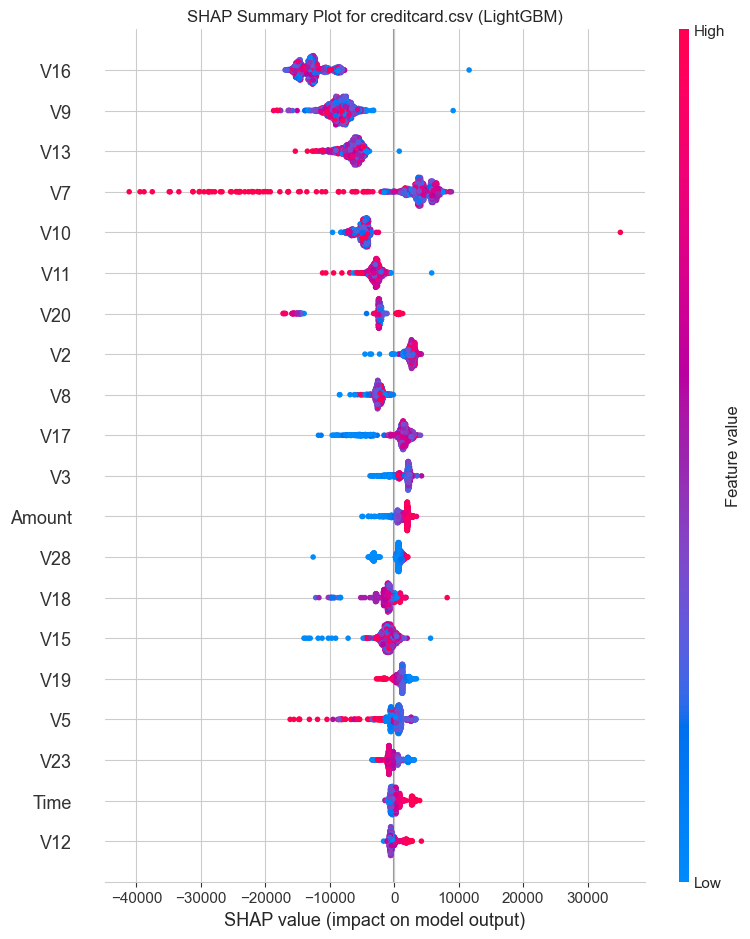


Generating SHAP Bar Plot for creditcard.csv...


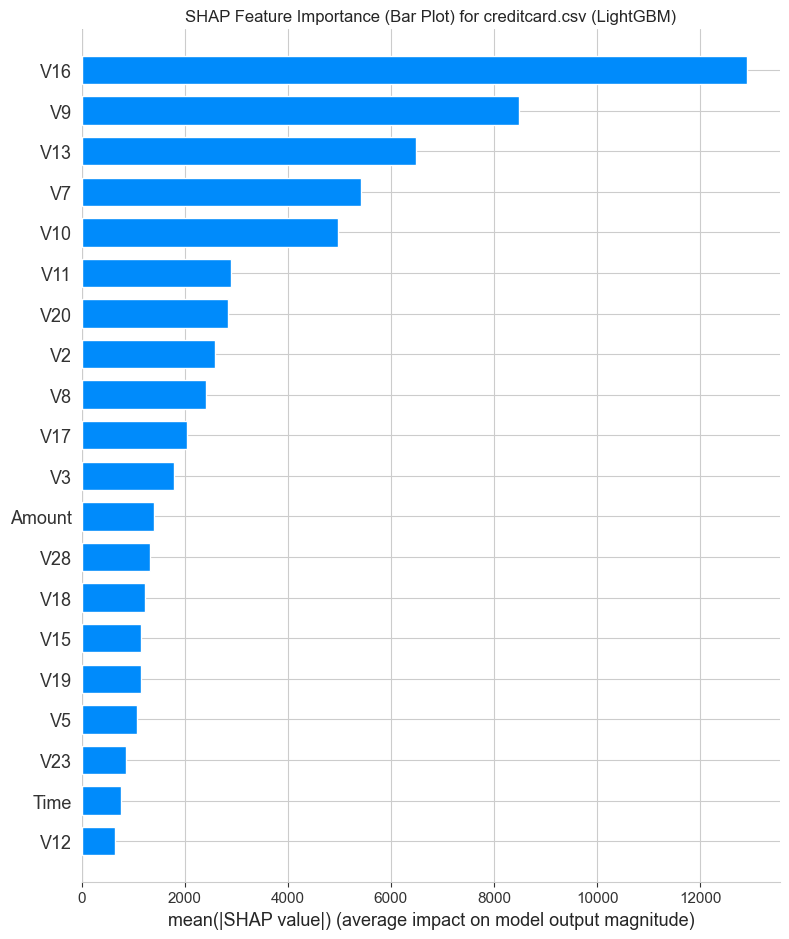


Generating SHAP Force Plot for a sample creditcard.csv transaction...


Force plot for a fraudulent credit card transaction (index 845 in processed test set):


In [17]:
# Import necessary libraries for SHAP (if not already imported in a previous cell)
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display # Needed for shap.force_plot in Jupyter

# Assuming X_test_processed_fraud, y_test_fraud, X_test_scaled_cc, y_test_cc
# and trained models lgbm_fraud, lgbm_cc are available from previous cells.
# Also assuming preprocessor_fraud, numerical_features_fraud, categorical_features_fraud, X_train_fraud are available.

print("\n--- Task 3: Model Explainability with SHAP ---")

# --- Helper function for getting column names from preprocessor ---
def get_column_names_from_preprocessor(preprocessor, numerical_features, categorical_features, X_original_train_df):
    """
    Dynamically gets the column names from a fitted ColumnTransformer.
    This version tries to correctly account for 'passthrough' if it exists.
    """
    output_features = []

    # Iterate through each transformer in the ColumnTransformer
    for name, pipeline, original_cols_input in preprocessor.transformers_:
        if name == 'num':
            # Numerical features are scaled, their names remain the same
            output_features.extend(numerical_features)
        elif name == 'cat':
            # Categorical features are one-hot encoded
            ohe_transformer = pipeline.named_steps['onehot']
            if hasattr(ohe_transformer, 'get_feature_names_out'):
                output_features.extend(ohe_transformer.get_feature_names_out(categorical_features))
            else:
                for i, col in enumerate(categorical_features):
                    for category in ohe_transformer.categories_[i]:
                        output_features.append(f"{col}_{category}")
                print("Warning: Using fallback for get_feature_names_out. Consider updating scikit-learn to >=0.23 for robustness.")
        elif name == 'remainder' and pipeline == 'passthrough':
            all_processed_cols_from_transformers = set(numerical_features + categorical_features)
            passthrough_cols = [col for col in X_original_train_df.columns if col not in all_processed_cols_from_transformers and col not in ['class', 'signup_time', 'purchase_time', 'ip_address', 'user_id', 'device_id']]
            output_features.extend(passthrough_cols)
    return output_features


# --- For Fraud_Data.csv (E-commerce) ---
print("\n--- SHAP Explanation for LightGBM (Fraud_Data) ---")

explainer_fraud = shap.TreeExplainer(lgbm_fraud)

try:
    all_feature_names_fraud = get_column_names_from_preprocessor(
        preprocessor_fraud, numerical_features_fraud, categorical_features_fraud, X_train_fraud
    )
except NameError as e:
    print(f"Error: Required variables for get_column_names_from_preprocessor are not defined: {e}")
    print("Please ensure Task 1 setup (data loading, splitting, preprocessing pipeline definition) has been successfully run.")
    all_feature_names_fraud = []
    X_test_processed_fraud_df = pd.DataFrame()
    print("SHAP plots for Fraud_Data skipped due to missing setup.")


if all_feature_names_fraud:
    print(f"Number of feature names generated for Fraud_Data by custom function: {len(all_feature_names_fraud)}")
    print(f"Shape of X_test_processed_fraud: {X_test_processed_fraud.shape}")

    print("\n--- DEEPER DIAGNOSTIC FOR X_test_processed_fraud ---")
    print(f"Type of X_test_processed_fraud: {type(X_test_processed_fraud)}")
    if 'sparse' in str(type(X_test_processed_fraud)):
        print(f"Is X_test_processed_fraud a SciPy sparse matrix? Yes. Type: {type(X_test_processed_fraud)}")
        print(f"X_test_processed_fraud.shape: {X_test_processed_fraud.shape}")
        print("Converting sparse matrix to dense array for DataFrame creation...")
        X_test_processed_fraud = X_test_processed_fraud.toarray()
        print(f"New shape after toarray(): {X_test_processed_fraud.shape}")
        print(f"New type after toarray(): {type(X_test_processed_fraud)}")
    elif isinstance(X_test_processed_fraud, np.ndarray):
        print(f"Is X_test_processed_fraud a NumPy array? Yes.")
        print(f"X_test_processed_fraud.ndim: {X_test_processed_fraud.ndim}")
        print(f"X_test_processed_fraud.shape[0]: {X_test_processed_fraud.shape[0]}")
        print(f"X_test_processed_fraud.shape[1]: {X_test_processed_fraud.shape[1]}")
    else:
        print(f"X_test_processed_fraud is neither a NumPy array nor a SciPy sparse matrix. Its type is: {type(X_test_processed_fraud)}")
    print("--- END DEEPER DIAGNOSTIC ---")


    if len(all_feature_names_fraud) != X_test_processed_fraud.shape[1]:
        print(f"!!!! CRITICAL MISMATCH ERROR FOR SHAP (Fraud_Data) !!!!")
        print(f"Column name count ({len(all_feature_names_fraud)}) "
              f"does not match transformed data column count ({X_test_processed_fraud.shape[1]}) for Fraud_Data.")
        print("This indicates that preprocessor_fraud.transform(X_test_fraud) is NOT producing the expected number of columns.")
        print("Please examine the output of 'DEEPER DIAGNOSTIC' sections previously provided or re-run Task 1 entirely.")
        print("SHAP plots for Fraud_Data skipped.")
    else:
        print(f"CONFIRMING SHAPE RIGHT BEFORE DATAFRAME: {X_test_processed_fraud.shape}")
        print(f"CONFIRMING COLUMN NAMES COUNT RIGHT BEFORE DATAFRAME: {len(all_feature_names_fraud)}")
        try:
            assert X_test_processed_fraud.shape[1] == len(all_feature_names_fraud)
            print("Assertion passed: X_test_processed_fraud column count matches feature names count.")
        except AssertionError:
            print("Assertion FAILED: X_test_processed_fraud column count DOES NOT match feature names count.")
            print("This is highly unexpected given previous prints. Check environment or cached variables.")
            raise

        X_test_processed_fraud_df = pd.DataFrame(X_test_processed_fraud, columns=all_feature_names_fraud)

        # Take a sample for SHAP explanation
        shap_sample_fraud = X_test_processed_fraud_df.sample(n=min(1000, X_test_processed_fraud_df.shape[0]), random_state=42)
        
        # --- NEW WORKAROUND: Calculate SHAP values sample by sample ---
        print("\nCalculating SHAP values sample by sample (workaround for batch processing issue)...")
        list_of_shap_values_for_class_1_fraud = []
        # Iterate through each row of the sample DataFrame
        for i in range(shap_sample_fraud.shape[0]):
            # Get a single row as a NumPy array and reshape to (1, n_features)
            single_sample_row = shap_sample_fraud.iloc[i].values.reshape(1, -1)
            
            # Calculate SHAP values for this single row
            single_shap_values_output = explainer_fraud.shap_values(single_sample_row)
            
            # --- ROBUST INDEXING FOR SHAP VALUES OUTPUT ---
            if isinstance(single_shap_values_output, list):
                # If it's a list, it usually contains values for each class.
                # For binary, it's typically [class0_values, class1_values].
                # If it's a list with only one element, it means that single element is the desired values.
                if len(single_shap_values_output) == 2:
                    shap_values_for_current_sample = single_shap_values_output[1] # For positive class
                elif len(single_shap_values_output) == 1:
                    shap_values_for_current_sample = single_shap_values_output[0] # The only element in the list
                else:
                    # This case should ideally not happen for binary classification
                    raise ValueError(f"Unexpected number of outputs ({len(single_shap_values_output)}) from explainer.shap_values for a single sample.")
            else:
                # If it's not a list, it means explainer.shap_values returned the values directly as a NumPy array.
                # This is common for LightGBM binary models where the output implicitly refers to the positive class.
                shap_values_for_current_sample = single_shap_values_output
            # --- END ROBUST INDEXING ---

            list_of_shap_values_for_class_1_fraud.append(shap_values_for_current_sample)

        # Stack the list of 1D arrays into a 2D array
        shap_values_for_plot_fraud = np.vstack(list_of_shap_values_for_class_1_fraud)
        # --- END NEW WORKAROUND ---

        # Explicitly check and print shapes right before the plot
        print(f"Shape of shap_sample_fraud (features for plot): {shap_sample_fraud.shape}")
        print(f"Shape of shap_values_for_plot_fraud (SHAP values): {shap_values_for_plot_fraud.shape}")
        
        # This assert should now pass if the workaround is effective
        assert shap_sample_fraud.shape[0] == shap_values_for_plot_fraud.shape[0], \
               "Mismatch in number of rows between features (shap_sample_fraud) and SHAP values! (Workaround failed)"

        # SHAP Summary Plot
        print("\nGenerating SHAP Summary Plot for Fraud_Data...")
        shap.summary_plot(shap_values_for_plot_fraud, shap_sample_fraud, show=False)
        plt.title('SHAP Summary Plot for Fraud_Data (LightGBM)')
        plt.tight_layout()
        plt.show()

        # SHAP Bar Plot (Feature Importance)
        print("\nGenerating SHAP Bar Plot for Fraud_Data...")
        shap.summary_plot(shap_values_for_plot_fraud, shap_sample_fraud, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance (Bar Plot) for Fraud_Data (LightGBM)')
        plt.tight_layout()
        plt.show()

        # SHAP Force Plot for a sample fraudulent transaction
        print("\nGenerating SHAP Force Plot for a sample Fraud_Data transaction...")
        fraud_processed_rows = X_test_processed_fraud_df[y_test_fraud.values == 1]
        
        if not fraud_processed_rows.empty:
            example_row_fraud = fraud_processed_rows.iloc[0]
            # For force_plot, explainer.shap_values will again return either a list or a direct array
            single_shap_values_output_force = explainer_fraud.shap_values(example_row_fraud.values.reshape(1, -1))
            
            # --- ROBUST INDEXING FOR FORCE PLOT SHAP VALUES ---
            if isinstance(single_shap_values_output_force, list):
                if len(single_shap_values_output_force) == 2:
                    shap_values_single_fraud = single_shap_values_output_force[1]
                elif len(single_shap_values_output_force) == 1:
                    shap_values_single_fraud = single_shap_values_output_force[0]
                else:
                    raise ValueError("Unexpected output format for force plot SHAP values.")
            else:
                shap_values_single_fraud = single_shap_values_output_force
            # --- END ROBUST INDEXING ---

            shap.initjs()
            print(f"Force plot for a fraudulent transaction (index {example_row_fraud.name} in processed test set):")
            # example_row_fraud (Series/1-row DF) is fine for `features` argument here
            # explainer.expected_value might also be a single float or a list depending on LightGBM output
            expected_value_for_force_plot_fraud = explainer_fraud.expected_value
            if isinstance(expected_value_for_force_plot_fraud, np.ndarray) and expected_value_for_force_plot_fraud.ndim > 0:
                expected_value_for_force_plot_fraud = expected_value_for_force_plot_fraud[1] if len(expected_value_for_force_plot_fraud) > 1 else expected_value_for_force_plot_fraud[0]
            
            display(shap.force_plot(expected_value_for_force_plot_fraud, shap_values_single_fraud, example_row_fraud))
        else:
            print("No fraudulent transactions found in the processed test set for SHAP Force Plot example.")


# --- For creditcard.csv (Bank Credit) ---
print("\n--- SHAP Explanation for LightGBM (creditcard.csv) ---")
explainer_cc = shap.TreeExplainer(lgbm_cc)

try:
    all_feature_names_cc = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)]
    X_test_scaled_cc_df = pd.DataFrame(X_test_scaled_cc, columns=all_feature_names_cc)
except NameError:
    print("Error: Required variables for creditcard.csv (e.g., X_test_scaled_cc) are not defined.")
    print("Please ensure Task 1 setup has been successfully run.")
    X_test_scaled_cc_df = pd.DataFrame()
    print("SHAP plots for creditcard.csv skipped due to missing setup.")


if not X_test_scaled_cc_df.empty:
    shap_sample_cc = X_test_scaled_cc_df.sample(n=min(1000, X_test_scaled_cc_df.shape[0]), random_state=42)
    
    # --- NEW WORKAROUND: Calculate SHAP values sample by sample ---
    print("\nCalculating SHAP values sample by sample (workaround for batch processing issue)...")
    list_of_shap_values_for_class_1_cc = []
    for i in range(shap_sample_cc.shape[0]):
        single_sample_row_cc = shap_sample_cc.iloc[i].values.reshape(1, -1)
        single_shap_values_output_cc = explainer_cc.shap_values(single_sample_row_cc)
        
        # --- ROBUST INDEXING FOR SHAP VALUES OUTPUT ---
        if isinstance(single_shap_values_output_cc, list):
            if len(single_shap_values_output_cc) == 2:
                shap_values_for_current_sample_cc = single_shap_values_output_cc[1]
            elif len(single_shap_values_output_cc) == 1:
                shap_values_for_current_sample_cc = single_shap_values_output_cc[0]
            else:
                raise ValueError("Unexpected number of outputs from explainer.shap_values for a single sample (credit card).")
        else:
            shap_values_for_current_sample_cc = single_shap_values_output_cc
        # --- END ROBUST INDEXING ---

        list_of_shap_values_for_class_1_cc.append(shap_values_for_current_sample_cc)
    shap_values_for_plot_cc = np.vstack(list_of_shap_values_for_class_1_cc)
    # --- END NEW WORKAROUND ---

    print(f"Shape of shap_sample_cc (features for plot): {shap_sample_cc.shape}")
    print(f"Shape of shap_values_for_plot_cc (SHAP values): {shap_values_for_plot_cc.shape}")

    assert shap_sample_cc.shape[0] == shap_values_for_plot_cc.shape[0], \
           "Mismatch in number of rows between features (shap_sample_cc) and SHAP values! (Workaround failed)"

    # SHAP Summary Plot
    print("\nGenerating SHAP Summary Plot for creditcard.csv...")
    shap.summary_plot(shap_values_for_plot_cc, shap_sample_cc, show=False)
    plt.title('SHAP Summary Plot for creditcard.csv (LightGBM)')
    plt.tight_layout()
    plt.show()

    # SHAP Bar Plot
    print("\nGenerating SHAP Bar Plot for creditcard.csv...")
    shap.summary_plot(shap_values_for_plot_cc, shap_sample_cc, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance (Bar Plot) for creditcard.csv (LightGBM)')
    plt.tight_layout()
    plt.show()

    # SHAP Force Plot for a sample fraudulent transaction
    print("\nGenerating SHAP Force Plot for a sample creditcard.csv transaction...")
    fraud_processed_rows_cc = X_test_scaled_cc_df[y_test_cc.values == 1]
    
    if not fraud_processed_rows_cc.empty:
        example_row_cc = fraud_processed_rows_cc.iloc[0]
        single_shap_values_output_force_cc = explainer_cc.shap_values(example_row_cc.values.reshape(1, -1))
        
        # --- ROBUST INDEXING FOR FORCE PLOT SHAP VALUES ---
        if isinstance(single_shap_values_output_force_cc, list):
            if len(single_shap_values_output_force_cc) == 2:
                shap_values_single_cc = single_shap_values_output_force_cc[1]
            elif len(single_shap_values_output_force_cc) == 1:
                shap_values_single_cc = single_shap_values_output_force_cc[0]
            else:
                raise ValueError("Unexpected output format for force plot SHAP values (credit card).")
        else:
            shap_values_single_cc = single_shap_values_output_force_cc
        # --- END ROBUST INDEXING ---
        
        shap.initjs()
        print(f"Force plot for a fraudulent credit card transaction (index {example_row_cc.name} in processed test set):")
        
        expected_value_for_force_plot_cc = explainer_cc.expected_value
        if isinstance(expected_value_for_force_plot_cc, np.ndarray) and expected_value_for_force_plot_cc.ndim > 0:
            expected_value_for_force_plot_cc = expected_value_for_force_plot_cc[1] if len(expected_value_for_force_plot_cc) > 1 else expected_value_for_force_plot_cc[0]

        display(shap.force_plot(expected_value_for_force_plot_cc, shap_values_single_cc, example_row_cc))
    else:
        print("No fraudulent transactions found in the processed test set for SHAP Force Plot example for creditcard.csv.")